## Neutral Network Model for CA Housing Dataset

#### 1. Prepare Data
Model specific pre-processing, including creating datasets and scaling data for neural network.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import dataset
dataset = pd.read_csv('datasets/preprocessed_dataset.csv')

# Define Number of iterations to Test
ITERATION_COUNT = 20

# dataset array
X_train = []
y_train = []
X_test  = []
y_test  = []

# For iterative Steps create 20 dataset variations
for i in range(0,ITERATION_COUNT):
    # Step 1: First split (Train: 80%, Test: 20%)
    train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42 + i)

    # Select the columns to scale (last two columns)
    cols_to_scale = ['longitude', 'latitude', 'median_income', 'median_house_value']

    # Initialize scaler and fit on training data only
    scaler = StandardScaler()
    train_scaled_values = scaler.fit_transform(train_set[cols_to_scale])
    test_scaled_values = scaler.transform(test_set[cols_to_scale])

    # Create new column names
    scaled_col_names = [f"{col}_scaled" for col in cols_to_scale]

    # Add scaled columns and drop originals
    for df, scaled_data in zip([train_set, test_set], [train_scaled_values, test_scaled_values]):
        for orig_col, scaled_col in zip(cols_to_scale, scaled_col_names):
            df[scaled_col] = scaled_data[:, scaled_col_names.index(scaled_col)]

    # Select features for model
    feature_cols = ['longitude_scaled', 'latitude_scaled', 'ocean_proximity_encoded', 'median_income_scaled',]
    target_col = 'median_house_value_scaled'

    # Extract features and targets and convert to numpy
    X_train.append(train_set[feature_cols].to_numpy())
    y_train.append(train_set[target_col].to_numpy())
    X_test.append(test_set[feature_cols].to_numpy())
    y_test.append(test_set[target_col].to_numpy())

#### 2. Define Model Parameters & Train Model
1. Define **Hyperparameter** Set for **Grid Search**
2. For each iteration:
    1. Define model --> use grid search to **optimize/train model**
    2. **Test model** and store results 

In [133]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Define hyperparameters to search over
param_grid = {
    'hidden_layer_sizes': [ # Many iterations were run to find a good set of layer sizes to test
        (16, 32, 32, 16),   # (Stoped once improvments became marginal / signs of overfitting occured)
        (16,32,64,32,16), 
        (16,64,128,64,16)
    ], 
    'activation': ['relu', 'tanh'], # Tested different Activation Functions
    'alpha': [0.0001, 0.001],       # Regularizarion values to test
    'solver': ['adam'],             # Always use adam optimization model
    'max_iter': [1000],             # Alwayys use 1000 iterations
    'early_stopping': [True],       # Use validation set to benchmark model performance and limit overfitting
    'n_iter_no_change' : [50],      # High Validation Patience to overcome it stopping too early
    'validation_fraction': [0.2]    # 20% of training data used as validation during training
}

# Testing Results
Neural_Network_MSE = []
Neural_Network_MAPE = []
Neural_Network_R2 = []

for i in range(0,ITERATION_COUNT):
    # Define base model
    mlp = MLPRegressor(random_state=42,)

    # Perform Grid Search with 3-fold cross-validation
    grid_search = GridSearchCV(
        mlp,
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2
    )

    # Fit only on the training set
    grid_search.fit(X_train[i], y_train[i])

    from sklearn.metrics import accuracy_score

    # Evaluate best model on the validation set
    best_model = grid_search.best_estimator_
    test_preds = best_model.predict(X_test[i])
    test_mse = mean_squared_error(y_test[i], test_preds)
    test_mape = mean_absolute_percentage_error(y_test[i], test_preds)
    test_r2 = r2_score(y_test[i], test_preds)

    # Print Results
    print(f"Best parameters found for iteration {i}: {grid_search.best_params_}")
    print(f"Test MSE with best model: {test_mse:.4f}")
    print(f"Test MAPE with best model : {test_mape:.4f}")
    print(f"Test R² score: {test_r2:.4f}")

    # Append to Results
    Neural_Network_MSE.append(test_mse)
    Neural_Network_MAPE.append(test_mape)
    Neural_Network_R2.append(test_r2)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found for iteration 0: {'activation': 'tanh', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (16, 64, 128, 64, 16), 'max_iter': 1000, 'n_iter_no_change': 50, 'solver': 'adam', 'validation_fraction': 0.2}
Test MSE with best model: 0.2387
Test MAPE with best model : 1.6932
Test R² score: 0.7573


#### 3. Make Boxplots of Results
1. Mean Squared Error
2. Mean Average Percentage Error
3. R^2

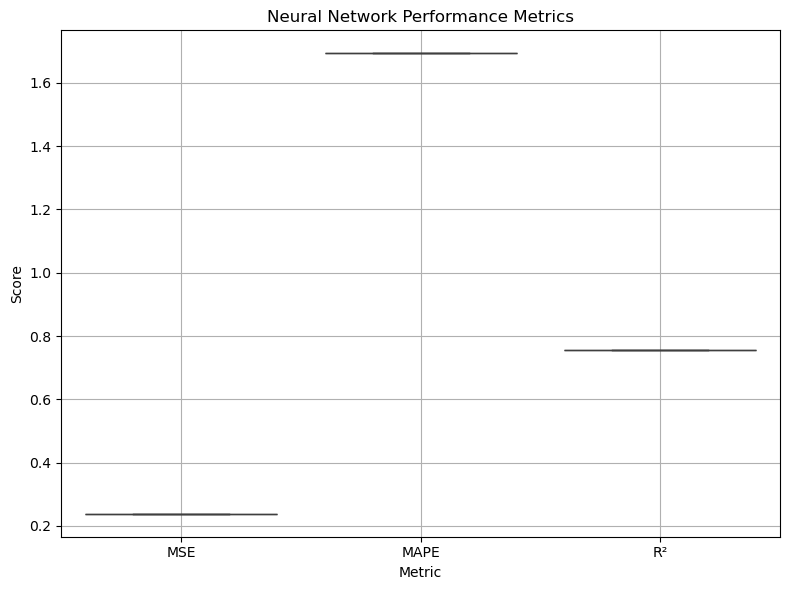

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data into a single DataFrame
data = pd.DataFrame({
    'MSE': Neural_Network_MSE,
    'MAPE': Neural_Network_MAPE,
    'R²': Neural_Network_R2
})

# Melt the DataFrame to long-form for seaborn
long_data = data.melt(var_name='Metric', value_name='Score')

# Plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Metric', y='Score', data=long_data)
plt.title("Neural Network Performance Metrics")
plt.grid(True)
plt.tight_layout()
plt.show()